In [64]:
BLENDSHAPE_MODEL_LANDMARKS_SUBSET = [0,   1,   4,   5,   6,   7,   8,   10,  13,  14,  17,  21,  33,  37,  39,
    40,  46,  52,  53,  54,  55,  58,  61,  63,  65,  66,  67,  70,  78,  80,
    81,  82,  84,  87,  88,  91,  93,  95,  103, 105, 107, 109, 127, 132, 133,
    136, 144, 145, 146, 148, 149, 150, 152, 153, 154, 155, 157, 158, 159, 160,
    161, 162, 163, 168, 172, 173, 176, 178, 181, 185, 191, 195, 197, 234, 246,
    249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291, 293, 295,
    296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324, 332, 334,
    336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380, 381, 382,
    384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409, 415, 454,
    466, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477]

BLENDSHAPE_NAMES = [
    "_neutral",
    "browDownLeft",
    "browDownRight",
    "browInnerUp",
    "browOuterUpLeft",
    "browOuterUpRight",
    "cheekPuff",
    "cheekSquintLeft",
    "cheekSquintRight",
    "eyeBlinkLeft",
    "eyeBlinkRight",
    "eyeLookDownLeft",
    "eyeLookDownRight",
    "eyeLookInLeft",
    "eyeLookInRight",
    "eyeLookOutLeft",
    "eyeLookOutRight",
    "eyeLookUpLeft",
    "eyeLookUpRight",
    "eyeSquintLeft",
    "eyeSquintRight",
    "eyeWideLeft",
    "eyeWideRight",
    "jawForward",
    "jawLeft",
    "jawOpen",
    "jawRight",
    "mouthClose",
    "mouthDimpleLeft",
    "mouthDimpleRight",
    "mouthFrownLeft",
    "mouthFrownRight",
    "mouthFunnel",
    "mouthLeft",
    "mouthLowerDownLeft",
    "mouthLowerDownRight",
    "mouthPressLeft",
    "mouthPressRight",
    "mouthPucker",
    "mouthRight",
    "mouthRollLower",
    "mouthRollUpper",
    "mouthShrugLower",
    "mouthShrugUpper",
    "mouthSmileLeft",
    "mouthSmileRight",
    "mouthStretchLeft",
    "mouthStretchRight",
    "mouthUpperUpLeft",
    "mouthUpperUpRight",
    "noseSneerLeft",
    "noseSneerRight"]

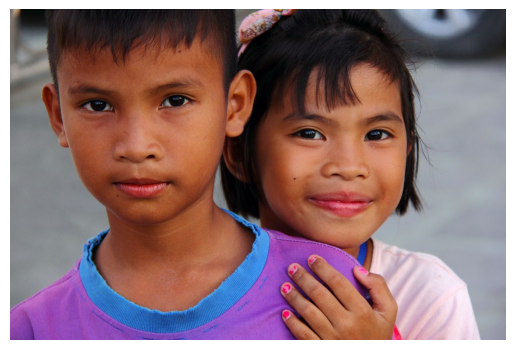

In [19]:
import cv2
import pylab as plt
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


IMAGE_FILE = 'image.jpg'


def cv2_imshow(img):
    plt.imshow(img[..., ::-1])
    plt.axis('off')
    plt.show()

img = cv2.imread(IMAGE_FILE)
cv2_imshow(img)
image_mp = mp.Image.create_from_file(IMAGE_FILE)

In [31]:
def init_mpipe_blendshapes_model():
    base_options = python.BaseOptions(
        model_asset_path="face_landmarker_v2_with_blendshapes.task",
        # delegate=mp.tasks.BaseOptions.Delegate.GPU,
        delegate=mp.tasks.BaseOptions.Delegate.CPU,
    )
    mp_mode = mp.tasks.vision.FaceDetectorOptions.running_mode.IMAGE
    options = vision.FaceLandmarkerOptions(
        base_options=base_options,
        running_mode=mp_mode,
        output_face_blendshapes=True,
        output_facial_transformation_matrixes=True,
        num_faces=10,
        # result_callback=self.result_callback,
    )
    return vision.FaceLandmarker.create_from_options(options)


mesh_detector = init_mpipe_blendshapes_model()
mesh_results = mesh_detector.detect(image_mp)

I0000 00:00:1710485921.670418   57349 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1710485921.695311   59895 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 545.29.06), renderer: NVIDIA GeForce RTX 3060 Laptop GPU/PCIe/SSE2
W0000 00:00:1710485921.695613   57349 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


In [76]:
# # Predicted with the tflite model instead of ONNX, but it seems results are identical so that can't be the issue
# import tensorflow as tf
# import numpy as np
# import cv2


# class TFLiteModel:
#     def __init__(self, model_path: str):
#         self.interpreter = tf.lite.Interpreter(model_path)
#         self.interpreter.allocate_tensors()

#         self.input_details = self.interpreter.get_input_details()
#         self.output_details = self.interpreter.get_output_details()

#     def predict(self, *data_args):
#         assert len(data_args) == len(self.input_details)
#         for data, details in zip(data_args, self.input_details):
#             self.interpreter.set_tensor(details["index"], data)
#         self.interpreter.invoke()
#         return self.interpreter.get_tensor(self.output_details[0]["index"])


# model = TFLiteModel("face_blendshapes.tflite")
# label = model.predict(landmarks_np[:1, np.array(BLENDSHAPE_MODEL_LANDMARKS_SUBSET), :2])
# label

In [33]:
import numpy as np

landmarks_np = []
for face_idx in range(len(mesh_results.face_landmarks)):
    landmarks_np.append(np.array([[i.x, i.y, i.z] for i in mesh_results.face_landmarks[face_idx]]))
landmarks_np = np.array(landmarks_np).astype('float32')
landmarks_np.shape

(2, 478, 3)

In [41]:
blendshapes_np = np.array([[mesh_results.face_blendshapes[face_idx][i].score for i in range(52)] for face_idx in range(len(mesh_results.face_landmarks))])
blendshapes_np.shape

(2, 52)

In [42]:
# mesh_results.face_landmarks

<BarContainer object of 52 artists>

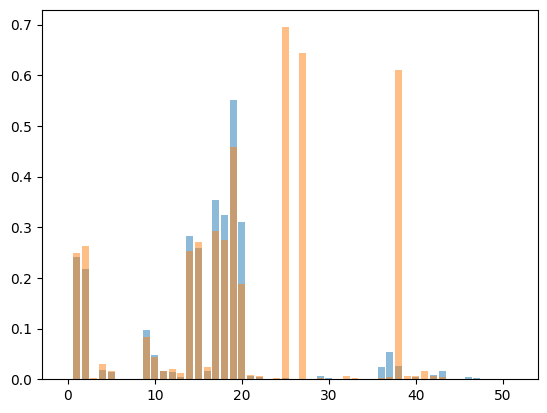

In [87]:
import numpy as np
import onnxruntime as rt

onnx_path = './face_blendshapes.onnx'
input_names, output_names = (['serving_default_input_points:0'], ['StatefulPartitionedCall:0'])

x = landmarks_np[:1, np.array(BLENDSHAPE_MODEL_LANDMARKS_SUBSET), :2]

providers = ['CPUExecutionProvider']
m = rt.InferenceSession(onnx_path, providers=providers)
onnx_pred = m.run(output_names, {input_names[0]: x})

plt.bar(range(52), blendshapes_np[0], alpha=0.5)
plt.bar(range(52), onnx_pred[0], alpha=0.5)

# print('ONNX Predicted:', onnx_pred[0])

In [67]:
onnx_pred[0].argsort()

array([ 8, 51, 50,  7,  0, 45, 31, 44, 30, 48, 49,  6, 23, 46, 47, 35, 34,
       28, 26, 24,  3, 33, 36, 29, 37, 43, 39, 40, 42, 22, 32, 21, 13, 41,
        5, 11, 12, 16,  4, 10,  9, 20,  1, 14,  2, 15, 18, 17, 19, 38, 27,
       25])

In [68]:
BLENDSHAPE_NAMES[38]

'mouthPucker'

In [73]:
label

array([2.01109174e-06, 2.48694107e-01, 2.62310892e-01, 1.56781485e-03,
       2.91793980e-02, 1.61387548e-02, 2.50289995e-05, 2.45471171e-07,
       1.01240744e-07, 8.28860253e-02, 4.40957472e-02, 1.71305556e-02,
       2.09452510e-02, 1.30958855e-02, 2.52877086e-01, 2.70581990e-01,
       2.35000085e-02, 2.92220086e-01, 2.75019169e-01, 4.57716972e-01,
       1.88403130e-01, 7.62616005e-03, 6.90279854e-03, 2.61683690e-05,
       1.54579757e-03, 6.94653988e-01, 1.37327006e-03, 6.44531131e-01,
       8.48972937e-04, 3.36726499e-03, 1.72145901e-05, 1.59938681e-05,
       7.39044230e-03, 2.01245351e-03, 6.09036477e-04, 3.34302196e-04,
       3.08662956e-03, 4.30950196e-03, 6.10640407e-01, 5.68841537e-03,
       5.81467617e-03, 1.61369517e-02, 6.17992366e-03, 4.45675198e-03,
       1.65485999e-05, 1.26615023e-05, 8.70925069e-05, 9.40261307e-05,
       1.90397368e-05, 2.11563020e-05, 2.20763255e-07, 1.90187890e-07],
      dtype=float32)

<BarContainer object of 52 artists>

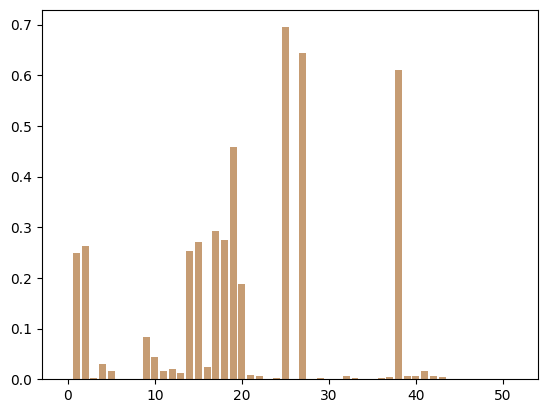

In [75]:
plt.bar(range(52), onnx_pred[0], alpha=0.5)
plt.bar(range(52), label, alpha=0.5)